# Reference:
## https://www.datacamp.com/community/tutorials/autoencoder-classifier-python

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import sys
sys.path.insert(0, '../')
sys.argv=['']; del sys
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from autoencoder import AUTOENCODER
from tqdm import trange
from keras.models import Model
from param import parse_argument
from models import encoder, decoder
import keras

from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.metrics import top_k_categorical_accuracy, categorical_crossentropy, categorical_accuracy
from keras.applications.mobilenet import preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import models
from keras.utils.training_utils import multi_gpu_model

Using TensorFlow backend.


# Setup

In [2]:
DP_DIR = '/data/doodle/train_sampled'
INPUT_DIR = '/data/doodle/'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [4]:
STEPS = 800
EPOCHS = 4
size = 64
epochs = 12
batchsize = 680
num_classes = 340

In [5]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y
                
def image_generator_xd_autoencoder(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                yield x, x

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [11]:
tmpgen = image_generator_xd(size, batchsize, range(99))

In [12]:
x, y = next(tmpgen)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

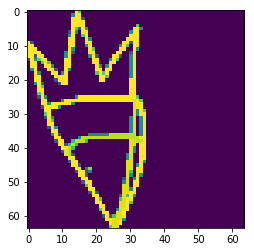

In [15]:
tmp = x[0].reshape((64,64))
plt.imshow(tmp)
print(y[0])

# Train model

In [16]:
# make train/valid generator
train_datagen = image_generator_xd_autoencoder(size=size, batchsize=batchsize, ks=range(NCSVS - 1))
validation_datagen = image_generator_xd_autoencoder(size=size, batchsize=batchsize, ks=range(NCSVS-1, NCSVS))

In [17]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=100)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(100, 64, 64, 1) (100, 340)
Validation array memory 0.00 GB


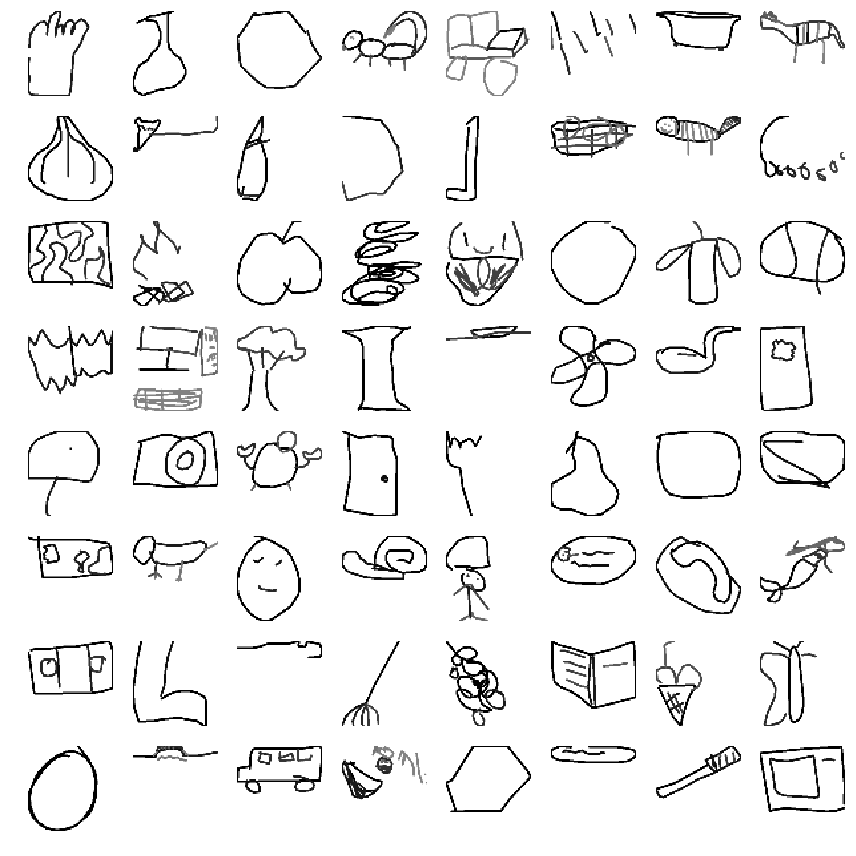

In [19]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    a = (-x[i]+1)/2
    a = ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    a = ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [11]:
inChannel = 1
input_img = Input(shape = (size, size, inChannel))
autoencoder = Model(input_img, decoder(encoder(input_img)))

try:
    1/0
    print('used multi-gpu')
    gpu_autoencoder = multi_gpu_model(autoencoder, gpus=2)
except:
    gpu_autoencoder = autoencoder
optimizer_param = {
    'loss':'mean_squared_error',
    'optimizer': RMSprop()
}
gpu_autoencoder.compile(**optimizer_param)

In [12]:
gpu_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
__________

In [13]:
callbacks = [
    ModelCheckpoint('/data/doodle/h5/autoencoder.h5'),
]

In [14]:
# make train/valid generator
train_datagen = image_generator_xd_autoencoder(size=size, batchsize=batchsize, ks=range(NCSVS - 1))
validation_datagen = image_generator_xd_autoencoder(size=size, batchsize=batchsize, ks=range(NCSVS-1, NCSVS))

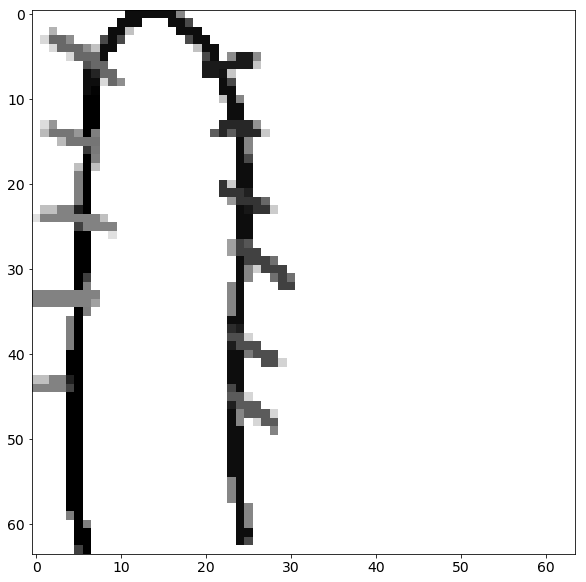

In [15]:
x, y = next(train_datagen)
plt.imshow(-x[0].reshape((64,64)), cmap=plt.cm.gray)

In [16]:
hist = gpu_autoencoder.fit_generator(
    train_datagen,
    steps_per_epoch=5000,
    epochs=epochs,
    verbose=1,
    validation_data=validation_datagen,
    validation_steps=50,
    callbacks = callbacks
)

Epoch 1/12
5000/5000 [==============================] - 1793s 359ms/step - loss: 0.8868 - val_loss: 0.8788
Epoch 2/12
5000/5000 [==============================] - 1798s 360ms/step - loss: 0.8790 - val_loss: 0.8792
Epoch 3/12
1002/5000 [=====>........................] - ETA: 24:01 - loss: 0.8788

KeyboardInterrupt: 

In [17]:
autoencoder.save_weights('/data/doodle/h5/autoencoder.h5')

# Check pre-trained autoencoder

In [18]:
# make train/valid generator
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))
validation_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS-1, NCSVS))

In [19]:
autoencoder.load_weights("/data/doodle/h5/autoencoder.h5")
print("Loaded model from disk")

Loaded model from disk


In [20]:
def run_encoder(enco):
    flat = Flatten()(enco)
    return flat

In [21]:
#encoded = Model(input_img, run_encoder(encoder))
encode = encoder(input_img)
only_encoding = Model(input_img, encode)
decoding = Model(input_img, decoder(encode))

In [22]:
category_dict = list_all_categories()

In [26]:
test_x_list = []
test_y_list = []
pred_list = []
decoded_list = []
for i in range(10):
    test_x, test_y = next(train_datagen)
    pred = only_encoding.predict(test_x)
    decoded = autoencoder.predict(test_x)
    
    test_x_list.extend(test_x)
    test_y_list.extend(np.argmax(test_y, axis=1))
    pred_list.extend(pred.reshape((-1,32,32, 128)))
    decoded_list.extend(decoded)

In [27]:
test_x_list = np.array(test_x_list)
test_y_list = np.array(test_y_list)
pred_list = np.array(pred_list)
decoded_list = np.array(decoded_list)
print(test_x_list.shape)
print(test_y_list.shape)
print(pred_list.shape)
print(decoded_list.shape)
#print(test_x_list[0].tolist())

(6800, 64, 64, 1)
(6800,)
(6800, 32, 32, 128)
(6800, 64, 64, 1)


baseball bat


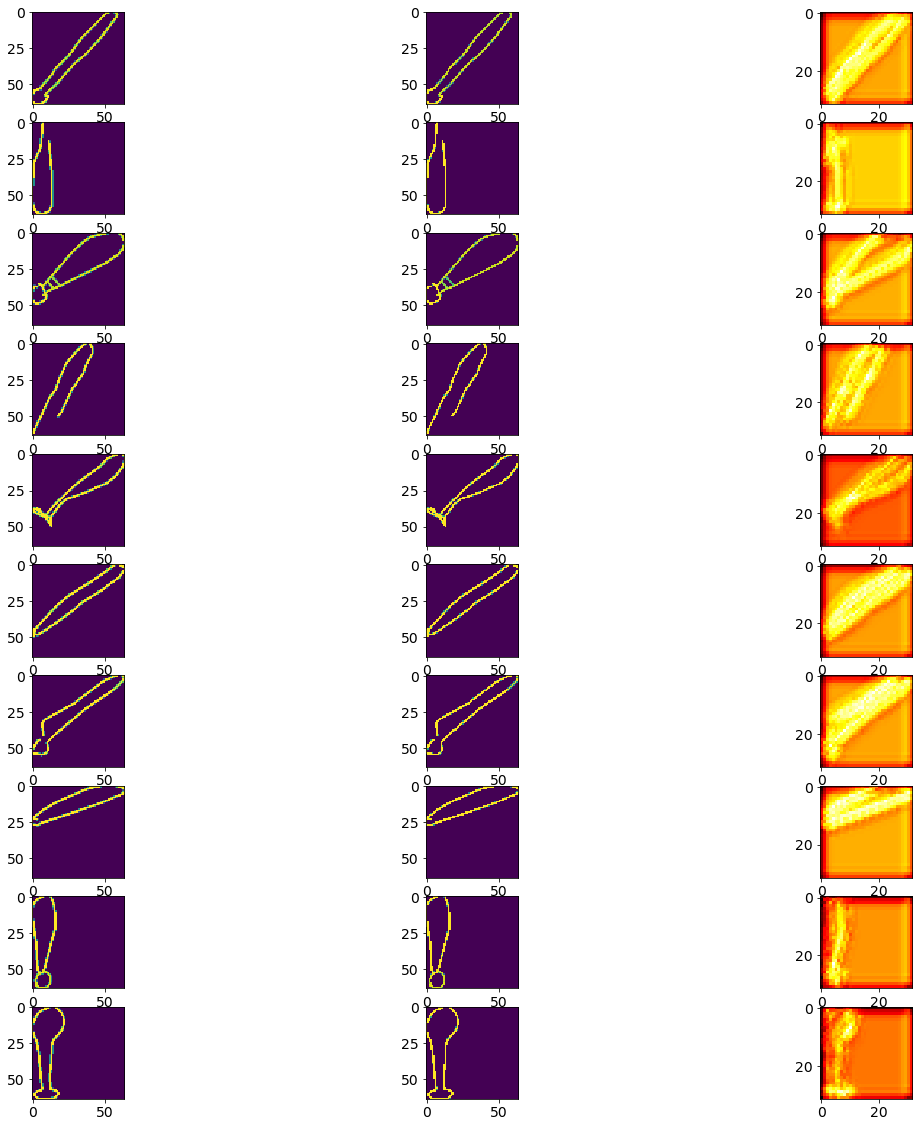

In [30]:
label = 16
idx = test_y_list == label
oneclass_test_x = test_x_list[idx]
oneclass_test_y = test_y_list[idx]
oneclass_pred_x = pred_list[idx]
oneclass_decoded = decoded_list[idx]

print(category_dict[label])
plt.figure(figsize=(20,20))
for i in range(10):
    # draw original image
    tmp = plt.subplot(10, 3, (i*3)+1)
    tmp = plt.imshow(oneclass_test_x[i].reshape(64, 64))
    
    # draw decoded image
    tmp = plt.subplot(10, 3, (i*3)+2)
    tmp = plt.imshow(oneclass_decoded[i].reshape(64, 64))
    
    # draw heatmap
    pred_reshape = np.reshape(oneclass_pred_x[i], [-1, 32*32, 128])
    pred_heatmap = np.sum(pred_reshape, axis=-1)
    tmp = plt.subplot(10, 3, (i*3)+3)
    tmp = plt.imshow(pred_heatmap.reshape((32,32)), cmap='hot', interpolation='nearest')

# Load full-model

In [20]:
def image_generator_xd_decoding(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                #decoded_x = autoencoder.predict(x)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

In [21]:
train_datagen = image_generator_xd(size, batchsize, ks=range(NCSVS - 1))
validation_datagen = image_generator_xd(size, batchsize, ks=range(NCSVS-1, NCSVS))

In [22]:
#print(autoencoder.input)
#print(autoencoder.output)
#print(mobile.input)
#print(mobile.output)
#merged = Model(inputs=[input_img], outputs=[mobile.output])
#print(len(autoencoder.layers))

full_model = models.Sequential()
#for layer in autoencoder.layers:
#    full_model.add(layer)

In [26]:
def fc(enco):
    mobile = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=num_classes)(enco)
    return mobile

In [28]:
decoding = decoder(encoder(input_img))
full_model = Model(input_img, fc(decoding))

In [29]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_51 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_52 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [35]:
full_model = multi_gpu_model(full_model, gpus=2)

In [36]:
full_model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

In [37]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
hists = []

In [38]:
# FIXME : epochs to 70
hist = full_model.fit_generator(
    train_datagen,
    steps_per_epoch=5000,
    epochs=16,
    verbose=1,
    validation_data=validation_datagen,
    validation_steps=50,
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/16
 133/5000 [..............................] - ETA: 31:02 - loss: 5.3053 - categorical_crossentropy: 5.3053 - categorical_accuracy: 0.0305 - top_3_accuracy: 0.0702

KeyboardInterrupt: 

In [82]:
tx, ty = next(train_datagen)
vx, vy = next(validation_datagen)

In [83]:
print(tx.shape, ty.shape)
print(vx.shape, vy.shape)

(680, 64, 64, 1) (680, 340)
(680, 64, 64, 1) (680, 340)


In [84]:
# FIXME : epochs to 70
hist = model.fit_generator(
    train_datagen,
    steps_per_epoch=5000,
    epochs=70,
    verbose=1,
    validation_data=validation_datagen,
    validation_steps=50,
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/70
  45/5000 [..............................] - ETA: 52:07 - loss: 5.5880 - categorical_crossentropy: 5.5880 - categorical_accuracy: 0.0144 - top_3_accuracy: 0.0382

KeyboardInterrupt: 

In [43]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [44]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [47]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [48]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_53 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_54 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [49]:
classify_train = full_model.fit_generator(
    train_datagen,
    steps_per_epoch=5000,
    epochs=epochs,
    verbose=1,
    validation_data=validation_datagen,
    validation_steps=50
)

Epoch 1/12
5000/5000 [==============================] - 414s 83ms/step - loss: 3.2199 - acc: 0.2999 - val_loss: 3.6249 - val_acc: 0.2615
Epoch 2/12
5000/5000 [==============================] - 410s 82ms/step - loss: 2.8607 - acc: 0.3592 - val_loss: 3.7521 - val_acc: 0.2636
Epoch 3/12
5000/5000 [==============================] - 413s 83ms/step - loss: 2.7572 - acc: 0.3785 - val_loss: 3.6962 - val_acc: 0.2667
Epoch 4/12
5000/5000 [==============================] - 413s 83ms/step - loss: 2.6915 - acc: 0.3904 - val_loss: 3.9157 - val_acc: 0.2519
Epoch 5/12
5000/5000 [==============================] - 409s 82ms/step - loss: 2.6855 - acc: 0.3918 - val_loss: 3.8375 - val_acc: 0.2627
Epoch 6/12
5000/5000 [==============================] - 410s 82ms/step - loss: 2.6737 - acc: 0.3944 - val_loss: 3.9074 - val_acc: 0.2576
Epoch 7/12
5000/5000 [==============================] - 411s 82ms/step - loss: 2.6327 - acc: 0.4020 - val_loss: 4.0051 - val_acc: 0.2556
Epoch 8/12
5000/5000 [===================